In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc 
import gsw as gs
import seawater as sw
from netCDF4 import Dataset, date2index
from mpl_toolkits.basemap import Basemap
import datetime as dt

### С помощью OPeNDAP Загрузим климатические данные о температуре воздуха из реанализов NCEP и NCEP2 

In [2]:
data_ncep1 = Dataset('http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/NCEP/NCEP/monthly/surface_gauss/air')
data_ncep2 = Dataset('http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/NCEP/NCEP2/monthly/gaussian_grid/air2m')

### Просмторим инофрмацию о переменных, входящих в выбранные датасеты

In [3]:
print(data_ncep1.variables.keys())
print(data_ncep2.variables.keys())

odict_keys(['time', 'lat', 'lon', 'air'])
odict_keys(['time', 'lev', 'lat', 'lon', 'air'])


### Также можно смотреть информацию о кажой конкретной переменной 

In [4]:
print(data_ncep2['air'])

<class 'netCDF4._netCDF4.Variable'>
float32 air(time, lev, lat, lon)
    _FillValue: 32766.0
    missing_value: 32766.0
    long_name: monthly mean of forecast of air temperature at 2 m 
unlimited dimensions: 
current shape = (482, 1, 94, 192)
filling off



In [5]:
#Выведете информацию о переменной температура воздуха в датасете NCEP2 

### Данные из реанализов NCEP1 и NCEP2 имеют различное временное покрытите, для их сравнения выберем интервал в период с 1980 по 2018 гг. 

In [6]:
date1 = dt.datetime(1980, 1, 1)
date2 = dt.datetime(2018, 12, 1)

timevar1 = data_ncep1.variables['time']
timevar2 = data_ncep2.variables['time']

timeindex11 = date2index(date1, timevar1)
timeindex12 = date2index(date2, timevar1)

timeindex21 = date2index(date1, timevar2)
timeindex22 = date2index(date2, timevar2)

print(timeindex11, timeindex12)
print(timeindex21, timeindex22)

384 851
12 479


In [7]:
t2m1 = data_ncep1['air'][timeindex11:timeindex12, :, :]
t2m2 = data_ncep2['air'][timeindex21:timeindex22, :, :, :]

t2m2 = np.squeeze(t2m2)

In [8]:
print(np.shape(t2m2))
print(np.shape(t2m1))

(467, 94, 192)
(467, 94, 192)


### Осредним переменные по времени до среднегодовых и по пространству 

In [9]:
t2m1 = np.reshape(t2m1, (467, 192*94))
t2m2 = np.reshape(t2m2, (467, 192*94))

print(np.shape(t2m2))
print(np.shape(t2m1))

(467, 18048)
(467, 18048)


In [10]:
# Осредняем по пространству 
t2m1_mean = np.mean(t2m1, axis = 1)
t2m2_mean = np.mean(t2m2, axis = 1)

print(np.shape(t2m1_mean))

(467,)


In [11]:
#Осредняем по времени до среднегодовых
a = 0
b = 12
yrs = 2019-1980
t2m1_yr = np.zeros(yrs)
t2m2_yr = np.zeros(yrs)

for i in range(int(yrs)):
    t2m1_yr[i] = np.mean(t2m1_mean[a:b], axis = 0)
    t2m2_yr[i] = np.mean(t2m2_mean[a:b], axis = 0)
    a = b
    b+=12

In [12]:
#Переводим в градусы Цельсия
t2m1_yr = t2m1_yr - 273.15
t2m2_yr = t2m2_yr - 273.15

### Данные обработаны — пришло время нарисовать их

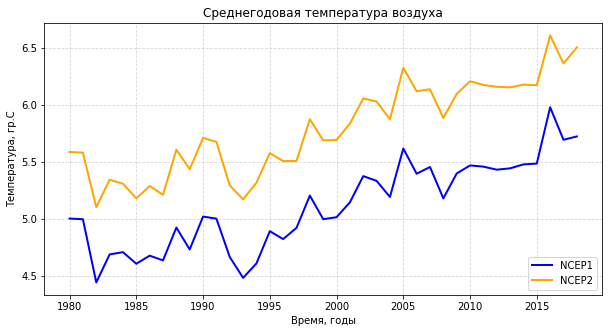

In [13]:
years = np.arange(1980, 2019)

fig1 = plt.figure(1, figsize = (10, 5))
plt.title('Среднегодовая температура воздуха')
plt.xlabel('Время, годы')
plt.ylabel('Температура, гр.С')
plt.plot(years, t2m1_yr, label = 'NCEP1', c = 'blue', lw = 2)
plt.plot(years, t2m2_yr, label = 'NCEP2', c = 'orange', lw = 2)
plt.grid(True, ls = '--', alpha = 0.5)
plt.legend(loc = 'lower right')
#plt.legend(loc = 'best')
plt.show()

### Видно, что данные хорошо коррелируют, но имеют разные? средние значения, а также положительный линейный тренд, давайте его рассчитаем 

### Расчет тренда в Python будем производить с помощью своей функции

In [14]:
def lin_trend(timesrc):
    
    from statsmodels.api import OLS
    
    time = np.arange(1, (len(timesrc)+1))
    ones = np.ones(len(timesrc))
    pred = np.vstack([time, ones])
    pred = np.transpose(pred)
    
    model = OLS(timesrc, pred)
    result = model.fit()
    
    print(result.summary())
    print('Regression coefficients:', result.params)
    
    lin_trend = result.params[0]*time+result.params[1]
    return(lin_trend)

### Теперь рассчитаем его

In [15]:
trend1 = lin_trend(t2m1_yr)
trend2 = lin_trend(t2m2_yr)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     112.6
Date:                Wed, 10 Apr 2019   Prob (F-statistic):           8.84e-13
Time:                        22:11:09   Log-Likelihood:                 9.8333
No. Observations:                  39   AIC:                            -15.67
Df Residuals:                      37   BIC:                            -12.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0292      0.003     10.613      0.0

### И нанесем на график

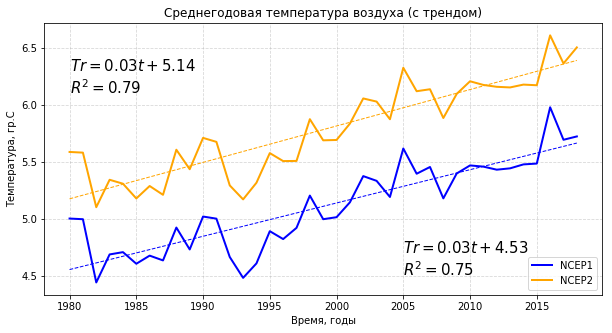

In [16]:
years = np.arange(1980, 2019)

fig1 = plt.figure(1, figsize = (10, 5))
plt.title('Среднегодовая температура воздуха (с трендом)')
plt.xlabel('Время, годы')
plt.ylabel('Температура, гр.С')
plt.plot(years, t2m1_yr, label = 'NCEP1', c = 'blue', lw = 2)
plt.plot(years, trend1, c = 'blue', lw = 1, ls = '--')

plt.text(2005, 4.7, '$Tr=0.03t+4.53$', size = 15)
plt.text(2005, 4.5, '$R^2=0.75$', size = 15)

plt.text(1980, 6.3, '$Tr=0.03t+5.14$', size = 15)
plt.text(1980, 6.1, '$R^2=0.79$', size = 15)

plt.plot(years, t2m2_yr, label = 'NCEP2', c = 'orange', lw = 2)
plt.plot(years, trend2, c = 'orange', lw = 1, ls = '--')
plt.grid(True, ls = '--', alpha = 0.5)
plt.legend(loc = 'lower right')
plt.show()

### Теперь выясним, действительно ли средние значения данных рядов статистически различны. Для  этого проверим статистические гипотезы, используя t-критерий Стьюдента 

In [17]:
mean1 = np.mean(t2m1_yr)
mean2 = np.mean(t2m2_yr)

print('Среднее NCEP1:', round(mean1, 2), ';', 'Среднее NCEP2:', round(mean2, 2))
sc.stats.ttest_ind(t2m1_yr, t2m2_yr)

Среднее NCEP1: 5.11 ; Среднее NCEP2: 5.78


Ttest_indResult(statistic=-7.4882890858559215, pvalue=1.0439476794429677e-10)

### Видим, что по t-критерию Стьюдента нулевая гипотеза отвергается, те средние значения статистически различны

### Теперь упражнение: постройте график среднегодовой температуры воздуха на 2 метрах на Земле (с нанесенным линейным трендом) за период c января 1980 по декабрь 2010, используя данные реанализа JRA-25 (ссылка OPeNDAP: http://apdrc.soest.hawaii.edu/dods/public_data/JRA-25/monthly-pressure) - название переменной: <span style="color:red"> *tmpsfc*</span>

### Теперь загрузим данные о среднемноголетних значениях температуры воды с буев argo (данные итерполированы в узлы регулярной сетки) 

In [45]:
data_argo = Dataset('http://apdrc.soest.hawaii.edu/dods/public_data/Argo_Products/annual_mean/Gridded_annual_mean')
print(data_argo.variables.keys())
print(data_argo['temp'])

odict_keys(['time', 'lev', 'lat', 'lon', 'temp', 'salt', 'ptemp', 'pden', 'addep', 'spice'])
<class 'netCDF4._netCDF4.Variable'>
float32 temp(time, lev, lat, lon)
    _FillValue: -999.0
    missing_value: -999.0
    long_name: argo temperature (degc) 
unlimited dimensions: 
current shape = (15, 27, 180, 360)
filling off



In [46]:
temp_argo = data_argo['temp'][:,:,:,:]

In [47]:
temp_argo = np.mean(temp_argo, axis = 0)

In [48]:
lat = data_argo['lat'][:]
lon = data_argo['lon'][:]

### С помощью бибилотеки matplotlib можно риосвать не только графики, но и пространства, нарисуем пространство ТПО по данным argo

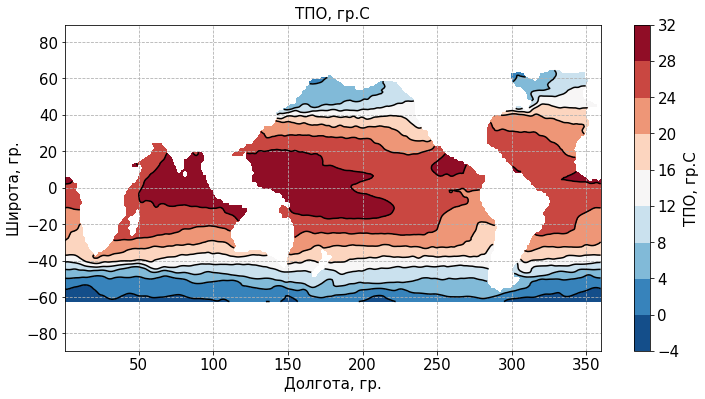

In [49]:
x, y = np.meshgrid(lon, lat)

fig2 = plt.figure(2, figsize = (12, 6))
plt.title('ТПО, гр.С', size = 15)
plt.xlabel('Долгота, гр.', size = 15)
plt.ylabel('Широта, гр.', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.grid(True, ls = '--', alpha = 1)
plt.contour(x, y, temp_argo[0,:,:], colors = 'black')
plt.contourf(x, y, temp_argo[0,:,:], cmap = 'RdBu_r')

cbar = plt.colorbar()
cbar.set_label('ТПО, гр.С',size=15)
cbar.ax.tick_params(labelsize=15) 

plt.show()

### Как можно заметить, matplotlib позволяет строить поля достаточно высокого качества, однако для гидрометеорологов зачастую необходимо наносить береговую линию, строить карты в различных географмческих проекциях и тд. Для решения даннного типа задач была разработана бибилотека Basemap. Теперь построим эту-же карту ТПО, но уже с помощью Basemap 

### На нашем рисунке долгота изменяется от 0 до 360, но Basemap поддерживает формат -180:180, поэтому неободимо привести наши данные к этому формату 

In [50]:
indx180 = np.where(lon > 180)
print(np.min(indx180))

180


In [51]:
temp_argo1 = temp_argo[:,:,:180]
temp_argo2 = temp_argo[:,:,180:]
print(np.shape(temp_argo1), np.shape(temp_argo2))

(27, 180, 180) (27, 180, 180)


In [52]:
temp_argo_new = np.ma.concatenate([temp_argo2, temp_argo1], axis = 2)
lon180 = np.arange(-180, 180, 1)
print(len(lon180), np.shape(temp_argo_new))

360 (27, 180, 360)


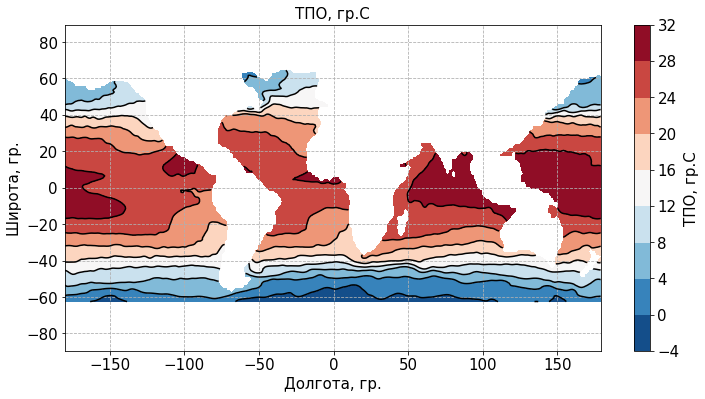

In [53]:
x, y = np.meshgrid(lon180, lat)

fig2 = plt.figure(2, figsize = (12, 6))
plt.title('ТПО, гр.С', size = 15)
plt.xlabel('Долгота, гр.', size = 15)
plt.ylabel('Широта, гр.', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.grid(True, ls = '--', alpha = 1)
plt.contour(x, y, temp_argo_new[0,:,:], colors = 'black')
plt.contourf(x, y, temp_argo_new[0,:,:], cmap = 'RdBu_r')

cbar = plt.colorbar()
cbar.set_label('ТПО, гр.С',size=15)
cbar.ax.tick_params(labelsize=15) 

plt.show()

### Теперь можно посторить это-же поле с использованием библиотеки Basemap, будем строить двумя функциями: уже известной нам функцией contourf и функцией pcolormesh 

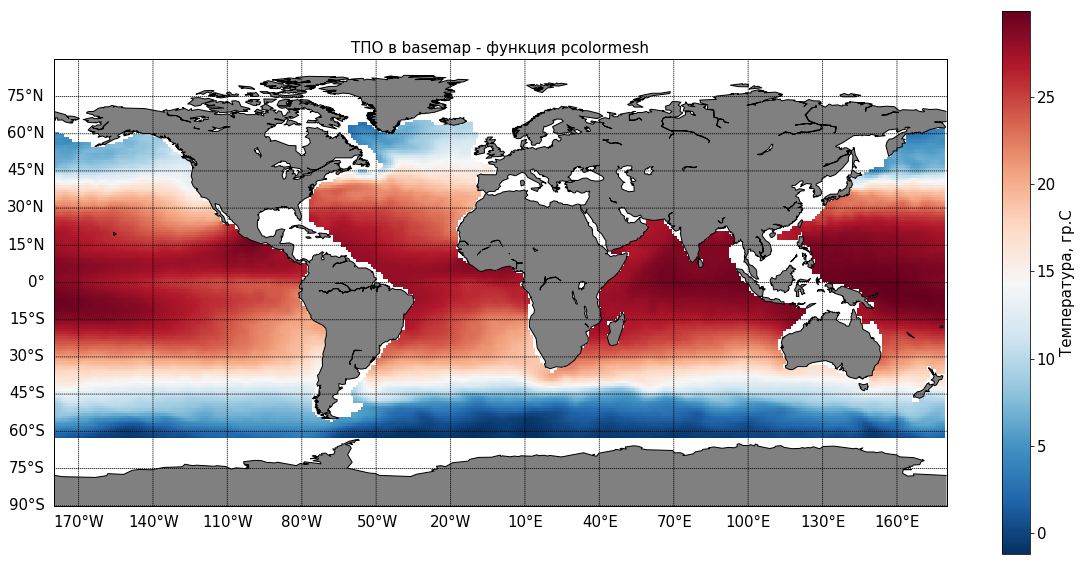

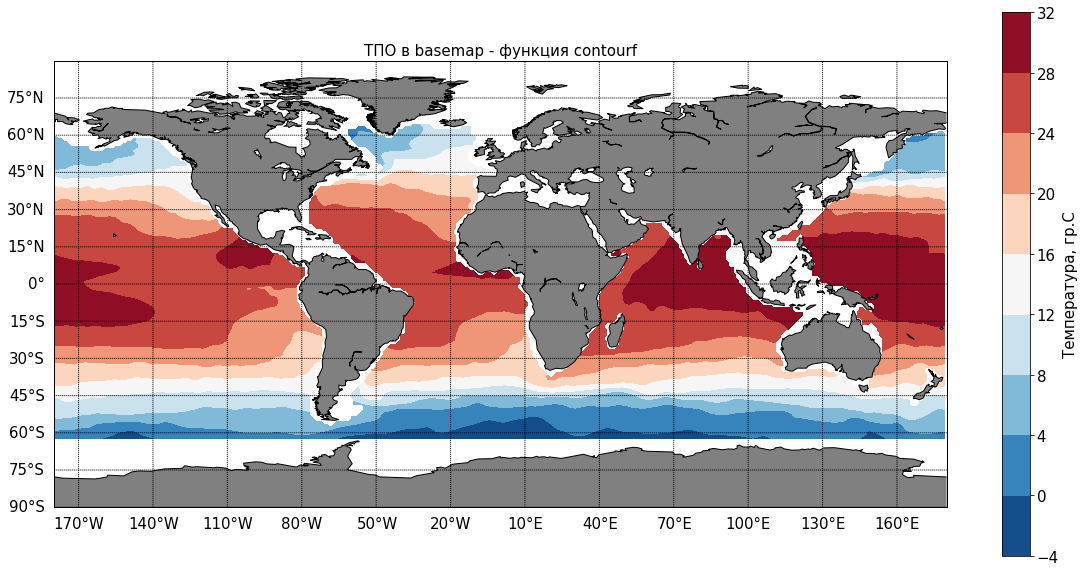

In [54]:
fig = plt.figure(3, figsize=(20,10))
#m = Basemap(projection='merc', resolution='c',llcrnrlon=(-180),llcrnrlat=(-90),urcrnrlon=180,urcrnrlat=90)
m = Basemap()
xx, yy = m(x, y)
m.drawcoastlines()
plt.title('ТПО в basemap - функция pcolormesh', size = 15)
surf = m.pcolormesh(xx, yy, temp_argo_new[0,:,:], cmap = 'RdBu_r')
m.fillcontinents(color='Gray')
m.drawmapboundary(fill_color='None')
m.drawparallels(np.arange(-90,90,15), labels=[1,0,0,0], fontsize=15)
m.drawmeridians(np.arange(-170,170,30), labels=[0,0,0,1], fontsize=15)
cbar = plt.colorbar()
cbar.set_label('Температура, гр.С',size=15)
cbar.ax.tick_params(labelsize=15) 
plt.show()


fig = plt.figure(4, figsize=(20,10))
#m = Basemap(projection='merc', resolution='c',llcrnrlon=(-180),llcrnrlat=(-90),urcrnrlon=180,urcrnrlat=90)
m = Basemap()
xx, yy = m(x, y)
m.drawcoastlines()
plt.title('ТПО в basemap - функция contourf', size = 15)
surf = m.contourf(xx, yy, temp_argo_new[0,:,:], cmap = 'RdBu_r')
m.fillcontinents(color='Gray')
m.drawmapboundary(fill_color='None')
m.drawparallels(np.arange(-90,90,15), labels=[1,0,0,0], fontsize=15)
m.drawmeridians(np.arange(-170,170,30), labels=[0,0,0,1], fontsize=15)
cbar = plt.colorbar()
cbar.set_label('Температура, гр.С',size=15)
cbar.ax.tick_params(labelsize=15) 
plt.show()

### Следует отметить, что Basemap поддерживает не только сушу, нарисованную закрашенными полигонами, но и, например, спутниковый снимок в качестве фона (blue marble)

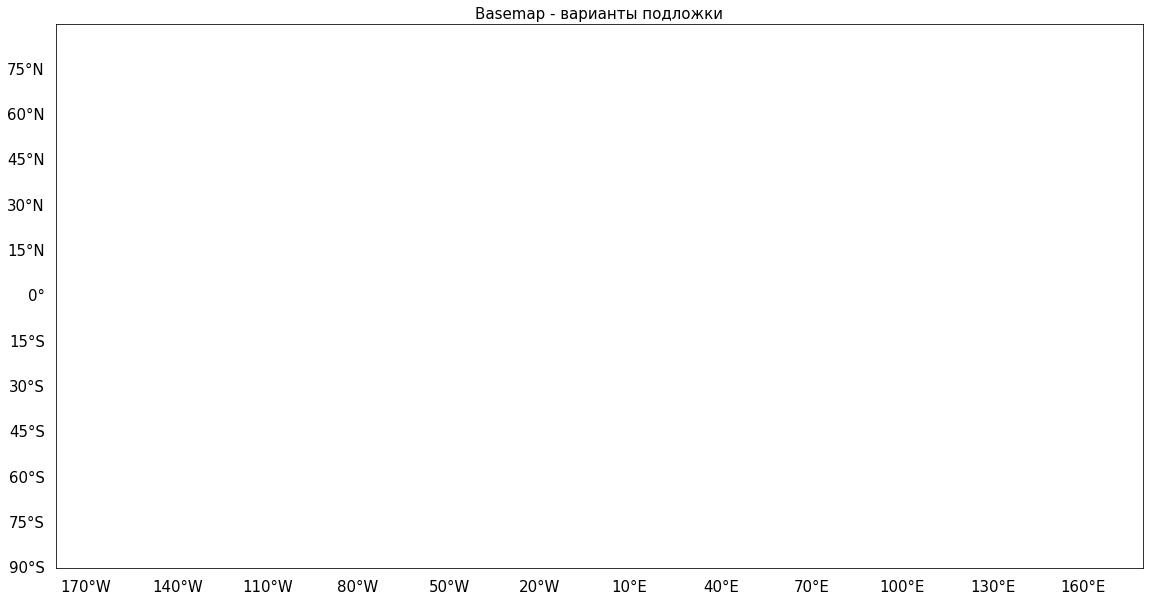

In [55]:
fig = plt.figure(5, figsize=(20,10))
m = Basemap()

####################Измените это######################
#m.bluemarble()
#m.shadedrelief()
#m.drawlsmask()
#m.etopo()
####################Измените это######################

plt.title('Basemap - варианты подложки', size = 15)
m.drawparallels(np.arange(-90,90,15), labels=[1,0,0,0], fontsize=15, color = 'white')
m.drawmeridians(np.arange(-170,170,30), labels=[0,0,0,1], fontsize=15, color = 'white')
plt.show()

###  Также с помощью Basemap можно нарисовать и отдельный регион. Давайте нарисуем Индийский океан. 

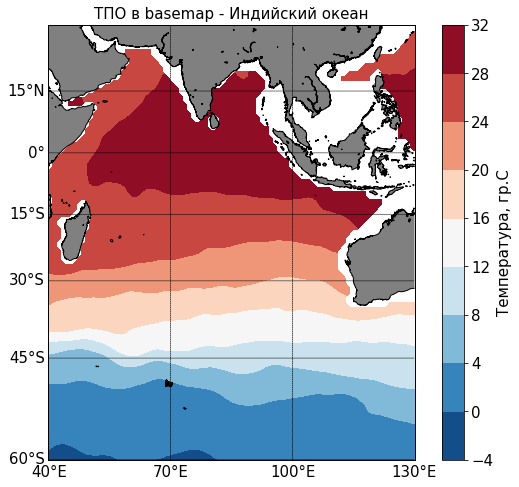

In [56]:
fig = plt.figure(6, figsize=(10,8))
m = Basemap(projection='merc', resolution='i',llcrnrlon=(40),llcrnrlat=(-60),urcrnrlon=130,urcrnrlat=(30))
xx, yy = m(x, y)
m.drawcoastlines()
plt.title('ТПО в basemap - Индийский океан', size = 15)
surf = m.contourf(xx, yy, temp_argo_new[0,:,:], cmap = 'RdBu_r')
m.fillcontinents(color='Gray')
m.drawmapboundary(fill_color='None')
m.drawparallels(np.arange(-90,90,15), labels=[1,0,0,0], fontsize=15)
m.drawmeridians(np.arange(-170,170,30), labels=[0,0,0,1], fontsize=15)
cbar = plt.colorbar()
cbar.set_label('Температура, гр.С',size=15)
cbar.ax.tick_params(labelsize=15) 
plt.show()

### Также в Basemap можно использовать различные проекции 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


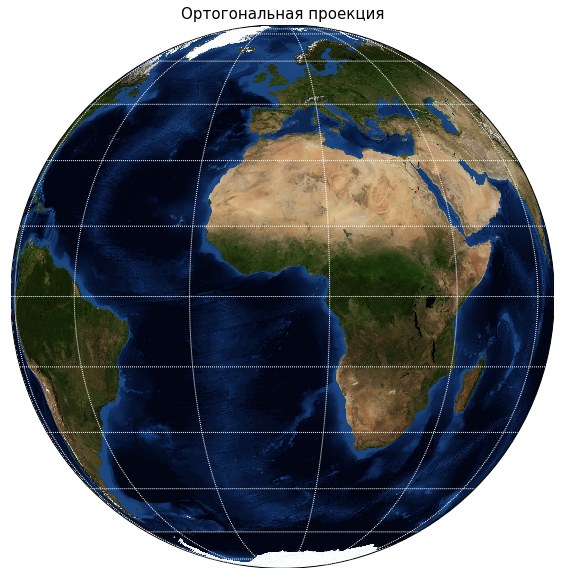

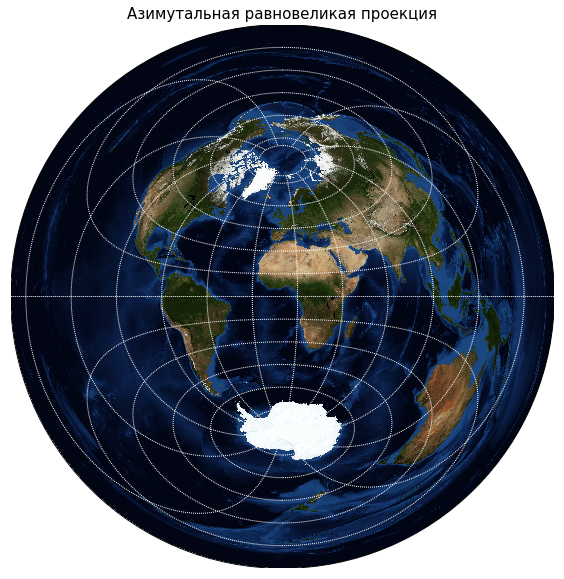

In [30]:
fig = plt.figure(7, figsize=(10,10))
m = Basemap(projection='ortho',lat_0=0, lon_0=0)
plt.title('Ортогональная проекция', size = 15)
m.bluemarble()
m.drawparallels(np.arange(-90,90,15), fontsize=15, color = 'white')
m.drawmeridians(np.arange(-170,170,30), fontsize=15, color = 'white')

fig = plt.figure(8, figsize=(10,10))
m = Basemap(projection='aeqd',lat_0=0,lon_0=0)
plt.title('Азимутальная равновеликая проекция', size = 15)
m.bluemarble()
m.drawparallels(np.arange(-90,90,15), fontsize=15, color = 'white')
m.drawmeridians(np.arange(-170,170,30), fontsize=15, color = 'white')
plt.show()



### Упраженение: постройте карут распределения поверхностной солености по данным буев Арго (переменная сожержится в ранее использованных данных), используйте проекцию Меркатора

### Теперь рассмотрим применение языка python для океанологических исследований, для этого используются библиотеки gsw (уравнение  состояния TEOS-10) и seawater (уравнение состояния УС-80)

### Рассчитаем среднеклиматические профили плотности по трем уравнениям состояния:  TEOS-10, УС-80 и линеаризованному, используя наши данные буев Argo. Для этого осредним их по пространству.

####  Линеаризованное уравнение состояния выглядит следующим образом:
#### $\rho=\rho_0(1-{\alpha}T+{\beta}S+kP)$, где:
#### $\rho_0$: плотность морской воды при T=0; S=0; P=0
#### $\alpha; \beta$: коэффициенты термического расширения и соленостного сжатия соответственно

In [57]:
salt_argo = data_argo['salt'][:,:,:,:]
salt_argo = np.mean(salt_argo, axis = 0)

temp_argo_prof = np.ma.reshape(temp_argo, (27, 180*360))
salt_argo_prof = np.ma.reshape(salt_argo, (27, 180*360))

temp_argo_prof = np.ma.mean(temp_argo_prof, axis = 1)
salt_argo_prof = np.ma.mean(salt_argo_prof, axis = 1)

### Построим полученные резульататы 

In [58]:
z = (data_argo['lev'][:])*(-1)

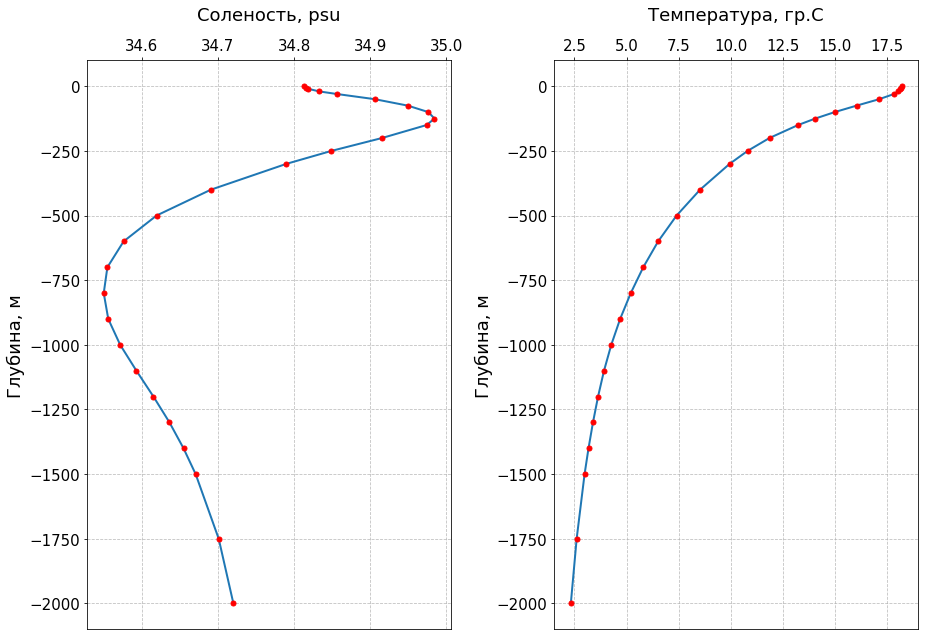

In [59]:
fig, ax = plt.subplots(figsize = (13, 9))
ax = plt.subplot(121)
ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False, labelsize = 15)
plt.grid(True, ls = '--', alpha = 0.8)
plt.plot(salt_argo_prof, z, lw = 2, marker = 'o', markersize = 5, markerfacecolor = 'r',  markeredgecolor = 'r')
plt.title('Соленость, psu', pad = 40, size = 18)
plt.ylabel('Глубина, м', size = 18)

ax = plt.subplot(122)
ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False, labelsize = 15)
plt.grid(True, ls = '--', alpha = 0.8)
plt.plot(temp_argo_prof, z, lw = 2, marker = 'o', markersize = 5, markerfacecolor = 'r',  markeredgecolor = 'r')
plt.title('Температура, гр.С', pad = 40, size = 18)
plt.ylabel('Глубина, м', size = 18)
fig.tight_layout()
plt.show()

In [60]:
press = gs.conversions.p_from_z(z, 0) #Считаем давление
ro_teos10 = gs.rho_t_exact(salt_argo_prof, temp_argo_prof, press) #Плотность по TEOS-10
ro_eos80 = sw.dens(salt_argo_prof, temp_argo_prof, press) #Плотность по УС-80
alpha = gs.alpha_wrt_t_exact(salt_argo_prof, temp_argo_prof, press) #Коэффициент термического расширение 
beta = gs.beta_const_t_exact(salt_argo_prof, temp_argo_prof, press) #Коэффициент соленостного сжатия  

### Для расчета k будем использовать свои собственную функцию (тк в пакетах  gsw и seawater их нет)

In [61]:
def k(t, s, p):
    cl = s/1.80655
    sigm0 = -0.069+1.4708*cl-0.001570*(cl**2)+0.0000398*(cl**3)
    k = ((4886/(1+0.0000183*p))-(227+28.33*t-0.551*(t**2)+0.004*(t**3))+(p*10**(-4))*(105.5+9.5*t-0.158*t**2) - (1.5*p**2)*t*10**(-8)-(((sigm0-28)/10))*((147.3-2.72*t+0.04*t**2)-(p*10**(-4))*(32.4-0.87*t+0.02*t**2))+(((sigm0-28)/10)**2)*(4.5-0.1*t-0.0001*p*(1.8-0.06*t)))*10**(-9)
    return(k)
    

In [62]:
k(20, 35, 0)

4.27942472248182e-06

In [63]:
temp_argo_prof = np.ma.getdata(temp_argo_prof)
salt_argo_prof = np.ma.getdata(salt_argo_prof)

In [64]:
mu = k(temp_argo_prof, salt_argo_prof, press)

In [71]:
ro_linear = gs.rho_t_exact(0, 0, 0)*(1-alpha*temp_argo_prof+beta*salt_argo_prof+mu*press)

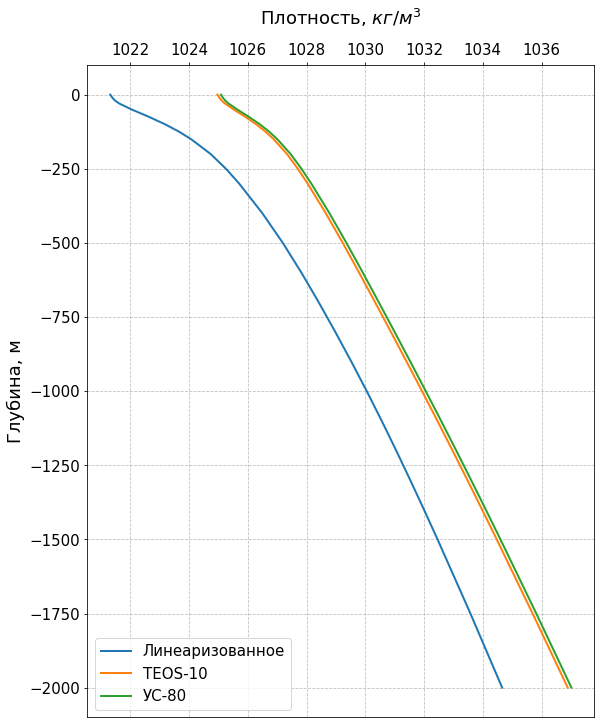

In [72]:
fig, ax = plt.subplots(figsize = (20, 12))

ax = plt.subplot(121)
ax.tick_params(top = True, labeltop = True, bottom = False, labelbottom = False, labelsize = 15)
plt.grid(True, ls = '--', alpha = 0.8)
plt.plot(ro_linear, z, lw = 2, label = 'Линеаризованное')
plt.plot(ro_teos10, z, lw = 2, label = 'TEOS-10')
plt.plot(ro_eos80, z, lw = 2, label = 'УС-80')
plt.title('Плотность, $кг/м^3$', pad = 40, size = 18)
plt.ylabel('Глубина, м', size = 18)
plt.legend(loc = 'lower left', prop={'size': 15})
plt.show()